In [168]:
import numpy as np

import torch
import torch.nn as nn
import torch.tensor as T

from torchvision import datasets, transforms
from tqdm.auto import tqdm
from IPython.display import Image, display

import matplotlib.pyplot as plt
from matplotlib import cm

from array2gif import write_gif

from time import time

torch.manual_seed(1)
DEVICE = 'cuda'

torch.cuda.is_available(), torch.__version__

(True, '1.2.0')

In [2]:
mnist = datasets.MNIST(
    '/home/izpc/data/mnist',
    download=True,
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]),

)

X = mnist.data.to(DEVICE).float() / 255.
y = mnist.targets.to(DEVICE).float()

IMG_SIZE = X.shape[-1]
FLAT_SIZE = IMG_SIZE * IMG_SIZE

X.shape ,y.shape, IMG_SIZE, FLAT_SIZE

(torch.Size([60000, 28, 28]), torch.Size([60000]), 28, 784)

In [3]:
def make_data_sampler(bs):
    while True:
        idx = np.random.randint(len(X), size=bs)
        yield T(X[idx, :])

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        def unit(a, b):
            return [
                nn.Linear(a, b),
                nn.ReLU(),
                nn.BatchNorm1d(b),
            ]

        self.encoder = nn.Sequential(
            *unit(FLAT_SIZE, 500),
            *unit(500, 500),
            *unit(500, 400),
            *unit(400, 300),
            *unit(300 , 10),
        )

        self.decoder = nn.Sequential(
            *unit(10 , 300),
            *unit(300, 500),
            *unit(500, 500),
            nn.Linear(500, FLAT_SIZE),
            nn.Sigmoid()
        )
        
        self.model = nn.Sequential(self.encoder, self.decoder)
        self.to(DEVICE)
        
    def forward(self, X):
        X = X.reshape(-1, FLAT_SIZE)
        reconstruction = self.model(X)
        
        return reconstruction.view(-1, IMG_SIZE, IMG_SIZE)
    
    def encode(self, X):
        X = X.reshape(-1, FLAT_SIZE)
        return self.encoder(X)
    
    def decode(self, X):
        return self.decoder(X).view(-1, IMG_SIZE, IMG_SIZE)

In [9]:
def plot_mapping(model, X):
    reconstructed = model(X)

    plot_size = 1.5

    num_imgs = X.shape[0]
    fig, axs = plt.subplots(2, num_imgs, figsize=(plot_size * num_imgs, plot_size * 2))

    for i in range(num_imgs):
        l, r = (axs[0, i], axs[1, i]) if num_imgs > 1 else (axs[0], axs[1])

        l.imshow(X[i].reshape(IMG_SIZE, -1).cpu().detach().numpy())
        r.imshow(reconstructed[i].reshape(IMG_SIZE, -1).cpu().detach().numpy())

        l.set_xticklabels([])
        r.set_xticklabels([])
        l.set_yticklabels([])
        r.set_yticklabels([])

    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

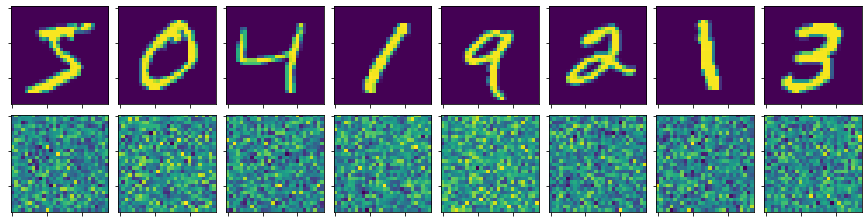

In [10]:
plot_mapping(Autoencoder(), X[:8])

In [11]:
def optimize(model, next_batch, its, lr=0.001):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_hist = []

    model.train()

    for i in tqdm(range(its)):
        batch = next(next_batch)
        logits = model(batch)

        loss = criterion(logits, batch)
        loss.backward()
        optimizer.step()

        cpu_loss = loss.data.cpu().numpy()
        loss_hist.append(cpu_loss)

        if i % 500 == 0:
            print('[%i]\t Batch Loss: %f' % (i, cpu_loss))
    
    model.eval()
            
    return loss_hist

In [12]:
AE = Autoencoder()
# AE

/home/izpc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


[0]	 Batch Loss: 0.731835
[500]	 Batch Loss: 0.635434
[1000]	 Batch Loss: 0.603475
[1500]	 Batch Loss: 0.560122
[2000]	 Batch Loss: 0.499197
[2500]	 Batch Loss: 0.429493
[3000]	 Batch Loss: 0.365352
[3500]	 Batch Loss: 0.311547
[4000]	 Batch Loss: 0.261473
[4500]	 Batch Loss: 0.224937
[5000]	 Batch Loss: 0.197724
[5500]	 Batch Loss: 0.179395
[6000]	 Batch Loss: 0.170535
[6500]	 Batch Loss: 0.157816
[7000]	 Batch Loss: 0.154410
[7500]	 Batch Loss: 0.149395
[8000]	 Batch Loss: 0.148765
[8500]	 Batch Loss: 0.141154
[9000]	 Batch Loss: 0.144223
[9500]	 Batch Loss: 0.138644



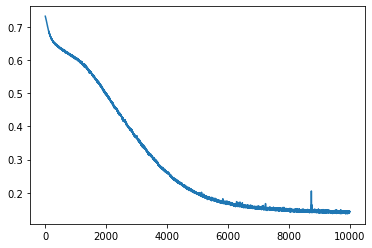

In [13]:
history = optimize(
    model=AE,
    its=10_000,
    next_batch=make_data_sampler(1024),
    lr=0.00001
)

plt.plot(history)

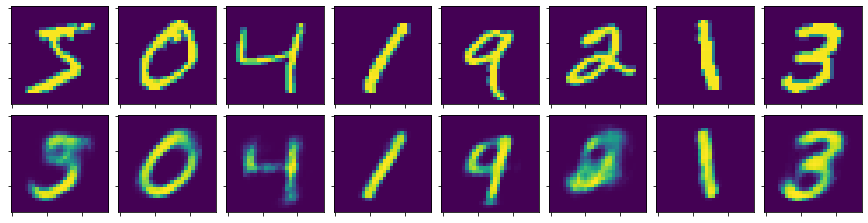

In [14]:
plot_mapping(AE, X[:8])

In [15]:
AE.encode(torch.rand(10000, 784).to(DEVICE)).shape

torch.Size([10000, 10])

In [16]:
examples = []

for i in range(10):
    example = X[y == i][1]
    examples.append(example.detach().cpu().numpy())
    
examples = T(np.array(examples)).to(DEVICE)
examples.shape

torch.Size([10, 28, 28])

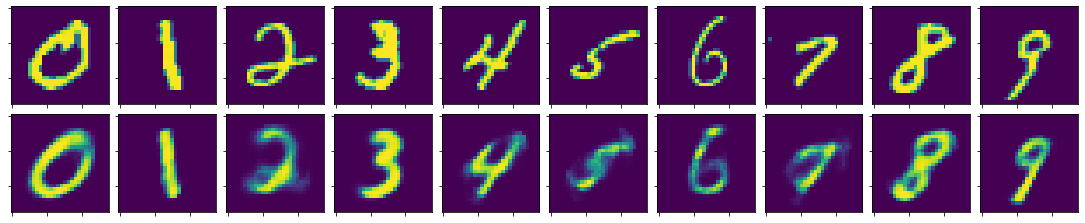

In [17]:
plot_mapping(AE, examples)

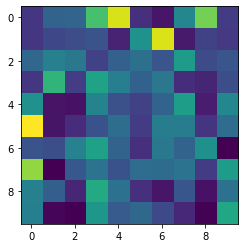

In [18]:
plt.imshow(AE.encode(examples).detach().cpu()) # Representations by row

In [212]:
def get_animation_frames():
    frames = []
    lerp_size = 8
    latent_reprs = AE.encode(examples)

    for num in range(10):
        for t in range(lerp_size):

            src = latent_reprs[num]
            target = latent_reprs[num + 1] if num < 9 else latent_reprs[0]

            lerp = torch.lerp(src, target, t / (lerp_size - 1)).unsqueeze(0)
            reconstruction = AE.decode(lerp).squeeze().detach().cpu()
            frames.append(reconstruction)
            
    cmap = cm.get_cmap('CMRmap')
    frames = [cmap(f)[:,:,:3].transpose(2, 0, 1) * 255 for f in frames]

    return frames

In [213]:
write_gif(get_animation_frames(), 'mnist_lerp.gif', fps=60)
display(Image(url='mnist_lerp.gif?%d' % time(), width=150))